## Gurhar Khalsa's Final Project


### Problem Statement and Goal
* This project focuses on using reinforcement learning techniques to train and agent to play Space Invaders
* The goal is to get the agent to learn strategies that are better than just taking random action choices

### The Environment
* The environment is a 210 by 160 pixel frame with rgb colors. Thus each frame is a 210x160x3 tensor. The agent has 6 action choices to choose from given an environment frame. The actions are move right, move left, move right and shoot, move left and shoot, shoot without moving, and no-op.

### Approach
* I created my own deep q learning agent. You can see from the code below that the training function has options for experience replay and non-experience replay. (see code comments)
* The agent is a deep q learning agent. Such an agent is like a q learning agent, but for state spaces in which a q table would be too small for the large state space. 
* The agent uses a neural network model to approximate the q table, refitting the model based on experiences interacting with the environment
* I also included epsilon decay so that the agent is more exploratory at first and settles on a more fixed strategy later in training
* Experience replay is a deep reinforcement learning technique in which the agent stores state, action, newstate, reward tuples it experiences while interacting with the environment in a memory buffer. It then uses randomly sampled minibatches from the experience buffer to train the model. This is helpful because a requirement of SGD optimization is that training data is independent and identically distributed. But training experience sequences are often highly correlated. Experience replay with random minibatch sampling avoids the negative effects of this correlation.

In [ ]:
!pip install tensorflow==2.3.1 gym keras-rl2 gym[atari]

In [1]:
!pip install PyVirtualDisplay
!sudo apt-get install xvfb

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  xvfb
0 upgraded, 1 newly installed, 0 to remove and 37 not upgraded.
Need to get 784 kB of archives.
After this operation, 2,270 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.9 [784 kB]
Fetched 784 kB in 1s (729 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package xvfb.
(Reading database ... 155222 files and directorie

In [2]:

import os
os.getcwd()
os.listdir()


['.config', 'sample_data']

In [3]:
os.mkdir('videos')

In [4]:
import urllib.request
urllib.request.urlretrieve('http://www.atarimania.com/roms/Roms.rar','Roms.rar')
!pip install unrar
!unrar x Roms.rar
!mkdir rars
!mv HC\ ROMS.zip   rars
!mv ROMS.zip  rars
!python -m atari_py.import_roms rars


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from Roms.rar

Extracting  HC ROMS.zip                                                 36  OK 
Extracting  ROMS.zip                                                    7 99  OK 
All OK
copying adventure.bin from ROMS/Adventure (1980) (Atari, Warren Robinett) (CX2613, CX2613P) (PAL).bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/adventure.bin
copying air_raid.bin from ROMS/Air Raid (Men-A-Vision) (PAL) ~.bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/air_raid.bin
copying alien.bin from ROMS/Alien (1982) (20th Century Fox Video Games, Douglas 'Dallas North' Neubauer) (11006) ~.bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/alien.bin
copying amidar.bin from ROMS/Amidar (1982) (Parker Brothers, Ed Temple) (PB5310) ~.bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/amidar.bin
copying assault.bin from ROMS/Assault (AKA Sky Alien) (1983) (Bom

In [5]:
import pickle
import gym  
from gym import wrappers
import numpy as np
#import pybullet_envs
import time  
import tensorflow as tf
import io
import glob
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
import os
import datetime
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install -U colabgymrender

In [ ]:
import numpy as np
#import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Convolution2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization, Dropout
from colabgymrender.recorder import Recorder
from collections import deque
import random

In [8]:

class myDQAgent():
    
    def __init__(self, model, env, epsilon=0.2, epsilon_lim=0.05, 
                 gamma=0.5, decay=0.9, batch_size=32, memory_limit=2000, replay=False):
        # Class for deep q agent. Takes a model, an environment and optional hyperparameters
        # to it's constructor
        self.model = model
        self.env = env
        self.epsilon = epsilon # 1-epsilon chance of random action choices during training
        self.epsilon_limit = epsilon_lim # a minimum bound on epsilon that decay cant go below
        self.discount = gamma # discount factor
        self.decay = decay # decay is applied to epsilon after each training round
        self.batch_size = batch_size 
        self.replay=replay # Boolean determines if training is done with or without memory buffer
        self.memory_limit = memory_limit # a limit on the size of the memory buffer
        self.memory = self.init_memory(self.memory_limit, self.batch_size, self.env)
        
    def init_memory(self, limit, batch_size, env):
        mem = deque(maxlen=limit)
        return mem

    def getActionValue(self, state):
        return np.max(self.model.predict(np.expand_dims(state, axis=0)))

    def getAction(self, state, rand=True):
        if rand == False: # Non randomized action choices
            pred = self.model.predict(np.expand_dims(state, axis=0))
            action = np.argmax(pred)
            return action
        else:
            if np.random.random() < self.epsilon: # action choices in accordance with epsilon hyperparameter
                return np.random.randint(0, self.env.action_space.n)
            else:
                pred = self.model.predict(np.expand_dims(state, axis=0))
             
                action = np.argmax(pred)
             
                return action

    def play_and_remember(self, episode):
        # This function is used with memory replay to play a round of 
        # space invaders and save all state, action, reward, newstate and done tuples
        # to be sampled randomly during training later
        done = False
        ep_reward = 0
        state = self.env.reset()
        while not done:
            action = self.getAction(state)
            new_state, reward, done, info = self.env.step(action)
            ep_reward += reward
            self.memory.append({"state":state, "action":action, "reward":reward, "new_state":new_state, "done": done})
            state = new_state
        print(f"Episode {episode + 1} results: Reward after terminal =  {ep_reward}, epsilon: {self.epsilon}")


    def train(self, n_episodes=5000):
            # Training function
            if self.replay: 
                # If replay is true, then we play and remember an episode
                for i in range(n_episodes):
                    
                    self.play_and_remember(i)
                    
                    if len(self.memory) > self.batch_size: 
                        # if the memory is sufficiently large, we sample it and
                        # train a batch
                        samples = random.sample(self.memory, self.batch_size)
                        X = []
                        ys = []
                        for sample in samples:
                            _action, _state, _new_state, _reward, _done = sample["action"], sample["state"], sample["new_state"], sample["reward"], sample["done"]
                     
                            if _done:
                                y = _reward
                            else:
                                y = _reward + self.discount * self.getActionValue(_new_state)
                            
                            targ_vec = self.model.predict(np.expand_dims(_state, axis=0))
                            targ_vec[0][_action] = y
                            X.append(_state)
                            ys.append(targ_vec[0])
                          
                        X = np.array(X)
                        ys = np.array(ys)
                        self.model.fit(X, ys, batch_size=self.batch_size, epochs=1, verbose=0)
                    
                    if self.epsilon > self.epsilon_limit:
                        self.epsilon *= self.decay

            else:
                # this is the training loop for non memory replay
                for i in range(n_episodes):
                    
                    state = np.asarray(env.reset())
                    done = False
                    ep_reward = 0
                    while not done:
                     
                        action = self.getAction(state)
                        new_state, reward, done, info = self.env.step(action)
                        new_state = np.asarray(new_state)
                        ep_reward += reward
                        if done:
                            print(f"Episode {i + 1}, Reward after terminal: {ep_reward}, epsilon = {self.epsilon}")
                        else:
                            y = reward + self.discount * self.getActionValue(new_state)
                        
                        targ_vec = self.model.predict(np.expand_dims(state, axis=0))
                        targ_vec[0][action] = y
                        self.model.fit(np.expand_dims(state, axis=0), targ_vec, batch_size=self.batch_size, epochs=1, verbose=0)
                        state = new_state
                    self.epsilon *= self.decay

class Qnet():
    # The Qnet is a convolutional neural net that has a light and not light option
    # this just means there is a choice for a larger or smaller model option
    def __init__(self,in_dim, actions, lr=1e-3, light=False):
        if light:
            self.model = self.build_model_light(in_dim, actions, lr)
        else:
            self.model = self.build_model(in_dim, actions, lr)
    
    def build_model(self, in_dim, actions, lr):
        model = Sequential()
        model.add(Convolution2D(128, (3, 3), activation='relu', input_shape=( 210, 160, 3)))
        model.add(Convolution2D(64, (3, 3), activation='relu'))
        model.add(Convolution2D(32, (3, 3), activation='relu'))

        model.add(Flatten())
    
        model.add(Dense(512, activation='relu'))
        model.add(Dense(actions, activation="linear"))
        optimizer = tf.keras.optimizers.Adam(
        learning_rate=lr)
        model.compile(optimizer, loss="mse")
        model.summary()
        return model

    def build_model_light(self, in_dim, actions, lr):
        model = Sequential()
        model.add(Convolution2D(32, (3, 3), activation='relu', input_shape=( 210, 160, 3)))
        model.add(Convolution2D(64, (3, 3), activation='relu'))
        model.add(Convolution2D(32, (3, 3), activation='relu'))

        model.add(Flatten())
    
        model.add(Dense(32, activation='relu'))
        model.add(Dense(actions, activation="linear"))
        optimizer = tf.keras.optimizers.Adam(
        learning_rate=lr)
        model.compile(optimizer, loss="mse")
        model.summary()
        return model
    

    




### Initial training with a smaller model and no experience replay:

In [14]:
env = gym.make("SpaceInvaders-v0")
env = Recorder(env, './video')
state = env.reset()
BATCH_SIZE = 64
actions = env.action_space.n
in_dim = env.observation_space.shape
print(in_dim)



(210, 160, 3)


In [15]:
qnet = Qnet(in_dim, actions, light=True).model

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 208, 158, 32)      896       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 206, 156, 64)      18496     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 204, 154, 32)      18464     
_________________________________________________________________
flatten_2 (Flatten)          (None, 1005312)           0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                32170016  
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 198       
Total params: 32,208,070
Trainable params: 32,208,070
Non-trainable params: 0
__________________________________________

In [16]:
agent = myDQAgent(model=qnet, env=env, epsilon=0.2,gamma=0.5, batch_size=BATCH_SIZE, decay=0.9)
agent.train(n_episodes=30)


Episode 1, Reward after terminal: 210.0, epsilon = 0.2
Episode 2, Reward after terminal: 590.0, epsilon = 0.18000000000000002
Episode 3, Reward after terminal: 460.0, epsilon = 0.16200000000000003
Episode 4, Reward after terminal: 210.0, epsilon = 0.14580000000000004
Episode 5, Reward after terminal: 105.0, epsilon = 0.13122000000000003
Episode 6, Reward after terminal: 135.0, epsilon = 0.11809800000000004
Episode 7, Reward after terminal: 460.0, epsilon = 0.10628820000000004
Episode 8, Reward after terminal: 180.0, epsilon = 0.09565938000000004
Episode 9, Reward after terminal: 155.0, epsilon = 0.08609344200000005
Episode 10, Reward after terminal: 105.0, epsilon = 0.07748409780000004
Episode 11, Reward after terminal: 155.0, epsilon = 0.06973568802000003
Episode 12, Reward after terminal: 260.0, epsilon = 0.06276211921800003
Episode 13, Reward after terminal: 245.0, epsilon = 0.056485907296200025
Episode 14, Reward after terminal: 260.0, epsilon = 0.050837316566580026
Episode 15, Rew

In [17]:
env = gym.make("SpaceInvaders-v0")
# env = Recorder(env, './video')
all_r = 0
random_rs = []
for i in range(100):
    observation = env.reset()
    done = False
    total_reward = 0
    while not done:
        action = env.action_space.sample()
        observation, reward, done, info = env.step(action)
        total_reward += reward
    # env.play()
    # print("Total reward:",total_reward)
    random_rs.append(total_reward)
    all_r += total_reward
print("avg_r", all_r/100)



avg_r 156.0


In [20]:
env = gym.make("SpaceInvaders-v0")
# 100 episode score averages or histogram comparison
all_r = 0
trained_rs = []
for i in range(100):
    
    observation = env.reset()
    done = False
    total_reward = 0
    while not done:
        
        action = agent.getAction(observation, rand=False)
        # print(action)
        observation, reward, done, info = env.step(action)
        total_reward += reward
    # env.play()
    # print("reward:",total_reward)
    trained_rs.append(total_reward)
    all_r += total_reward
print("avg_r", all_r/100)


avg_r 285.0


In [21]:
trained_rs

[285.0,
 285.0,
 285.0,
 285.0,
 285.0,
 285.0,
 285.0,
 285.0,
 285.0,
 285.0,
 285.0,
 285.0,
 285.0,
 285.0,
 285.0,
 285.0,
 285.0,
 285.0,
 285.0,
 285.0,
 285.0,
 285.0,
 285.0,
 285.0,
 285.0,
 285.0,
 285.0,
 285.0,
 285.0,
 285.0,
 285.0,
 285.0,
 285.0,
 285.0,
 285.0,
 285.0,
 285.0,
 285.0,
 285.0,
 285.0,
 285.0,
 285.0,
 285.0,
 285.0,
 285.0,
 285.0,
 285.0,
 285.0,
 285.0,
 285.0,
 285.0,
 285.0,
 285.0,
 285.0,
 285.0,
 285.0,
 285.0,
 285.0,
 285.0,
 285.0,
 285.0,
 285.0,
 285.0,
 285.0,
 285.0,
 285.0,
 285.0,
 285.0,
 285.0,
 285.0,
 285.0,
 285.0,
 285.0,
 285.0,
 285.0,
 285.0,
 285.0,
 285.0,
 285.0,
 285.0,
 285.0,
 285.0,
 285.0,
 285.0,
 285.0,
 285.0,
 285.0,
 285.0,
 285.0,
 285.0,
 285.0,
 285.0,
 285.0,
 285.0,
 285.0,
 285.0,
 285.0,
 285.0,
 285.0,
 285.0]

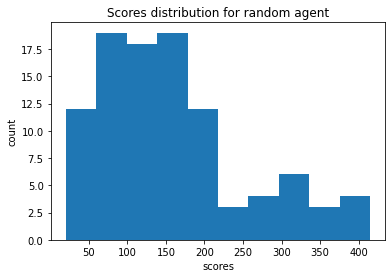

In [22]:
plt.title("Scores distribution for random agent")
plt.xlabel("scores")
plt.ylabel("count")
plt.hist(random_rs);

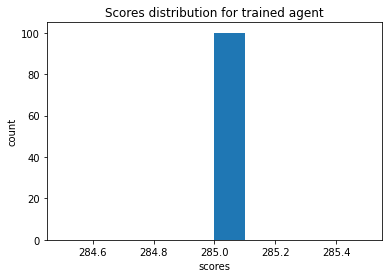

In [23]:
plt.title("Scores distribution for trained agent")
plt.xlabel("scores")
plt.ylabel("count")
plt.hist(trained_rs);

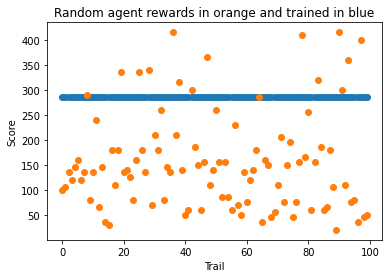

In [24]:
plt.scatter(range(len(trained_rs)),trained_rs);
plt.scatter(range(len(random_rs)),random_rs);
plt.ylabel("Score");
plt.xlabel("Trail")
plt.title("Random agent rewards in orange and trained in blue");



### The above comparison shows that on 100 trials, the average reward of the trained agent is better than that of a random agent.
* The random agent had a few exceptions where it got a decent score, but most of the time it got a bad score.
* The trained agent learned a fixed strategy

In [25]:
env = gym.make("SpaceInvaders-v0")
env = Recorder(env, './video')

observation = env.reset()
done = False
total_reward = 0
while not done:
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)
    total_reward += reward
print("Total reward of a random agent:", total_reward)
env.play()


Total reward of a random agent: 105.0


#### See untrained.mp4 for above video

In [26]:

# agent.epsilon = .00
observation = env.reset()
done = False
total_reward = 0
while not done:
    action = agent.getAction(observation, rand=False)
    observation, reward, done, info = env.step(action)
    total_reward += reward
print("Total reward of a deep q agent:", total_reward)
env.play()

Total reward of a deep q agent: 285.0


#### See noReplay285.mp4 for above video
* also, see noReplay270.mp4 for another example of a simple strategy learned by the agent without experience replay

### The agent learned a very basic strategy. But one that works better than just making random moves on average


* It seems like the agent has found and stuck to a local minimum in the strategy space.
* Ive included another example in noReplay270.mp4 of a simple strategy learned by the agent without experience replay
* This result also makes sense given the hyperparameters. The somewhat low epsilon favors known good strategies over exploration and the gamma parameter is not very high, which favors early rewards
* It also makes sense that the agent gets the same score every game since "The original Atari 2600 console had no feature for generating random numbers. As a consequence, the ALE is also fully deterministic." (https://towardsdatascience.com/are-the-space-invaders-deterministic-or-stochastic-595a30becae2#:~:text=The%20original%20Atari%202600%20console,learning%20to%20make%20good%20decisions)

* <b> Note</b>: the agent trained with experience replay (later in this noteboook) did not always get the same score. To my understanding, open AI's implementation does introduce a small amount of stochasticity. It therefore makes sense that some strategies might always yeild the same score, and some might interact with the stochasticity of the environment in such a way as to not have deterministic outcomes 


### Now lets use a larger model and experience replay:




In [5]:
qnet = Qnet(in_dim, actions).model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 208, 158, 128)     3584      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 206, 156, 64)      73792     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 204, 154, 32)      18464     
_________________________________________________________________
flatten (Flatten)            (None, 1005312)           0         
_________________________________________________________________
dense (Dense)                (None, 512)               514720256 
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 3078      
Total params: 514,819,174
Trainable params: 514,819,174
Non-trainable params: 0
__________________________________________

In [7]:
agent = myDQAgent(model=qnet, env=env, epsilon=.2, gamma=0.6, decay=0.99, memory_limit=100000, epsilon_lim=0.05,
                  batch_size=BATCH_SIZE, replay=True)
agent.train(n_episodes=20) # <-- 16 episodes might be better



Episode 1 results: Reward after terminal =  225.0, epsilon: 0.2
Episode 2 results: Reward after terminal =  180.0, epsilon: 0.198
Episode 3 results: Reward after terminal =  85.0, epsilon: 0.19602
Episode 4 results: Reward after terminal =  410.0, epsilon: 0.1940598
Episode 5 results: Reward after terminal =  105.0, epsilon: 0.192119202
Episode 6 results: Reward after terminal =  90.0, epsilon: 0.19019800998
Episode 7 results: Reward after terminal =  305.0, epsilon: 0.1882960298802
Episode 8 results: Reward after terminal =  105.0, epsilon: 0.186413069581398
Episode 9 results: Reward after terminal =  420.0, epsilon: 0.18454893888558402
Episode 10 results: Reward after terminal =  345.0, epsilon: 0.18270344949672818
Episode 11 results: Reward after terminal =  215.0, epsilon: 0.18087641500176088
Episode 12 results: Reward after terminal =  485.0, epsilon: 0.17906765085174328
Episode 13 results: Reward after terminal =  135.0, epsilon: 0.17727697434322584
Episode 14 results: Reward aft

KeyboardInterrupt: ignored

In [29]:
env = gym.make("SpaceInvaders-v0")
env = Recorder(env, './video')

all_r = 0
# trained_rs = []
for i in range(15):
    observation = env.reset()
    done = False
    total_reward = 0
    while not done:
        action = agent.getAction(observation, rand=False)
        observation, reward, done, info = env.step(action)
        total_reward += reward
    
    print("reward:",total_reward)
    # trained_rs.append(total_reward)
    all_r += total_reward
print("avg_r:", all_r/15)




reward: 270.0
reward: 440.0
reward: 170.0
reward: 175.0
reward: 250.0
reward: 445.0
reward: 265.0
reward: 205.0
reward: 565.0
reward: 435.0
reward: 450.0
reward: 175.0
reward: 345.0
reward: 175.0
reward: 400.0
avg_r: 317.6666666666667


In [31]:
env = gym.make("SpaceInvaders-v0")
env = Recorder(env, './video')
observation = env.reset()
done = False
total_reward = 0
while not done:
    action = agent.getAction(observation, rand=False)
    observation, reward, done, info = env.step(action)
    total_reward += reward
print("Total reward of a deep q agent with memory replay:", total_reward)
env.play()

Total reward of a deep q agent with memory replay: 450.0


#### See wExperienceReplay.mp4 for above video

### Above are results from an experience replay agent
* Notice the slight improvement on the agent without experience replay.
* The agent with memory replay now gets an average score of 315 (on 15 trials)
* More training and hyperparameter tuning would likely result in even better scores


### Conclusions and Suggestions for Further Work
* Ideally I would have been able to get even better performance out of the experience replay agent. However, I am pleased that my agent still performed better on average than a random agent and that my replay agent seems to have been a little better than my agent without experience replay.
* Also improvement of the replay agent is still promising. It just takes a long time to train the agent, and there are many different hyperparameter configurations to consider. 
* I think that with more time to tune the hyperparameters I could have gotten better performance out of the experience replay agent and this is a suggestion for further work. 
* Additionally, experimenting with different neural network architectures could improve results.


### References:
* https://towardsdatascience.com/deep-q-network-dqn-ii-b6bf911b6b2c
* https://towardsdatascience.com/are-the-space-invaders-deterministic-or-stochastic-595a30becae2#:~:text=The%20original%20Atari%202600%20console,learning%20to%20make%20good%20decisions
* https://towardsdatascience.com/deep-q-learning-tutorial-mindqn-2a4c855abffc
* https://towardsdatascience.com/introduction-to-various-reinforcement-learning-algorithms-i-q-learning-sarsa-dqn-ddpg-72a5e0cb6287
* https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf